# Classifiers Gravitational Wave Demo

## Setup

In [143]:
import os
import sys
import copy
import json
import pathlib
import numpy as np
import pandas as pd
import scipy
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# ensure project root (with 'config/' and 'src/') is on sys.path
project_root = pathlib.Path.cwd().resolve()
if not (project_root / "config").exists():
    candidate = project_root.parent
    if (candidate / "config").exists():
        project_root = candidate
if (project_root / "config").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Using project root: {project_root}")

from config import configs
from src.data_prep.gw_processing import process_gw_backgrounds, process_gw_signals, gw_background_split
from src.data_prep.utils import preprocess_params_fit, logit_transform, standardize, inverse_transform
from src.models.model_B import DensityEstimator, anode
from src.models.model_S import flows_model_RQS, r_anode_mass_joint_untransformed
from scipy.stats import rv_histogram

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "mps":
    torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float32)

torch.manual_seed(42)

Using project root: /Users/krishwu/code/ranode
Using device: mps


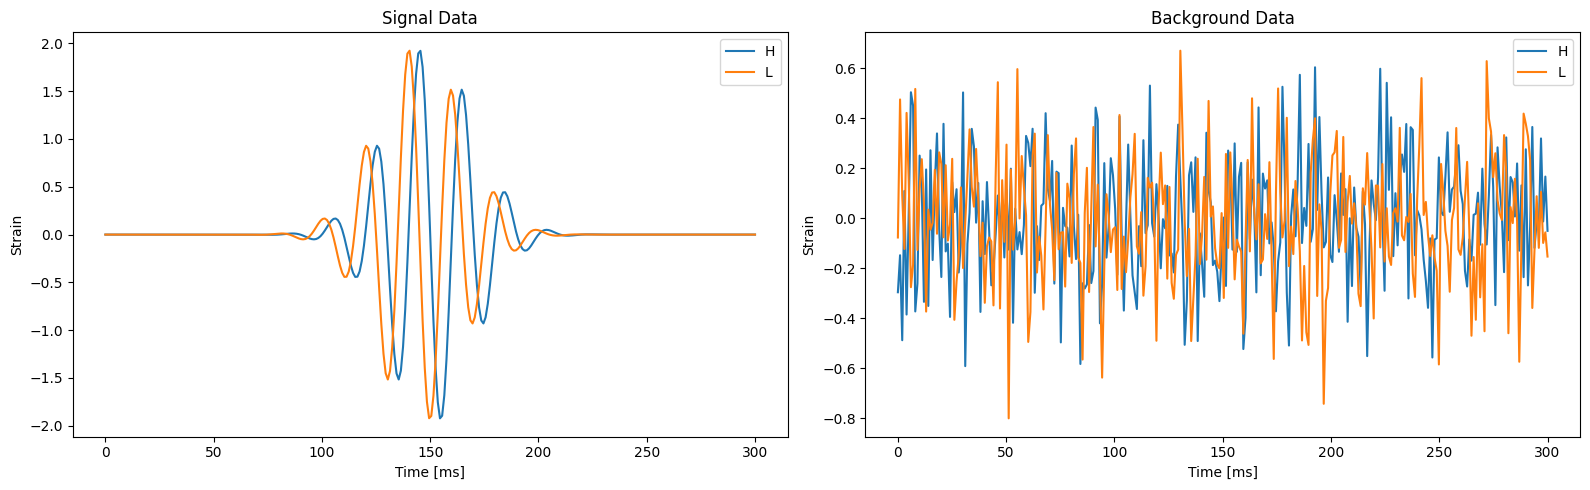

In [144]:
def gen_sig(amplitude=100.0):
    """Generate toy signal data mimicking gravitational wave detection.
    
    Parameters
    ----------
    amplitude : float, default=100.0
        Signal amplitude scaling factor
    
    Returns
    -------
    numpy.ndarray
        Generated signal data with gravitational wave-like characteristics
    """
    T = 20.0 # ms
    delta = 5. # ms
    A = amplitude
    return gen_data(A,T,delta,0)

def gen_bg():
    """Generate toy background data for gravitational wave analysis.
    
    Returns
    -------
    numpy.ndarray
        Generated background data without signal components
    """
    T = 20.0 # ms
    delta = 5. # ms
    A = 0.0
    return gen_data(A,T,delta,0.25)

def gen_data(A, T, delta, noise):
    """Generate simulated gravitational wave detector data.
    
    Creates toy data mimicking gravitational wave signals in dual detectors
    with configurable amplitude, period, time delay, and noise levels.
    
    Parameters
    ----------
    A : float
        Signal amplitude
    T : float
        Signal period in milliseconds
    delta : float
        Time delay between detectors in milliseconds
    noise : float
        Gaussian noise standard deviation
        
    Returns
    -------
    numpy.ndarray, shape (100, 5)
        Generated data with columns [time, H_detector, L_detector, H+L, H-L]
        
    Notes
    -----
    This is a toy model for testing R-Anode methodology on simple
    time-series data before applying to particle physics datasets.
    """
    data = []
    for t in np.linspace(0,300,num=300): #ms
        h = A * np.sin(2*np.pi*t / T) * scipy.stats.norm.pdf(t,loc=150,scale=20) + np.random.normal(scale=noise)
        l = A * np.sin(2*np.pi*(t+delta) / T)* scipy.stats.norm.pdf(t+delta,loc=150,scale=20) + np.random.normal(scale=noise)
        data.append( [ t,h,l])

    return np.array(data)

sdata = gen_sig()
bdata = gen_bg()

# Plot signal and background data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Signal data
ax1.plot(sdata[:,0],sdata[:,1],label="H")
ax1.plot(sdata[:,0],sdata[:,2],label="L")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Strain")
ax1.set_title("Signal Data")
ax1.legend()

# Background data
ax2.plot(bdata[:,0],bdata[:,1],label="H")
ax2.plot(bdata[:,0],bdata[:,2],label="L")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Strain")
ax2.set_title("Background Data")
ax2.legend()

plt.tight_layout()
plt.show()

Verified: signal is added sample-wise to the background
Background shape: (300, 3)
Signal template shape: (300, 3)
Signal+background combined shape: (300, 3)
Columns: [time, H, L, H+L, H-L, label]


[]

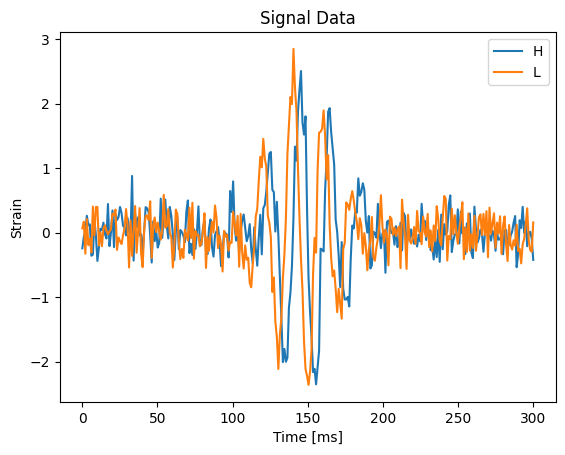

In [145]:
SIGNAL_AMPLITUDE = 120.0  # tweak amplitude to study sensitivity

raw_bkg = gen_bg()
raw_sig = gen_sig(amplitude=SIGNAL_AMPLITUDE)

def combine_signal_with_background(background: np.ndarray, signal: np.ndarray, scale: float = 1.0) -> np.ndarray:
    if background.shape != signal.shape:
        raise ValueError("Signal and background must share identical shape")
    combined = background.copy()
    if not np.allclose(background[:, 0], signal[:, 0], atol=1e-8):
        raise ValueError("Time grids for signal and background do not align")
    combined[:, 1] = background[:, 1] + scale * signal[:, 1]
    combined[:, 2] = background[:, 2] + scale * signal[:, 2]
    return combined

combined_signal_raw = combine_signal_with_background(raw_bkg, raw_sig)
assert np.allclose(combined_signal_raw[:, 0], raw_bkg[:, 0])
assert np.allclose(combined_signal_raw[:, 1] - raw_bkg[:, 1], raw_sig[:, 1])
assert np.allclose(combined_signal_raw[:, 2] - raw_bkg[:, 2], raw_sig[:, 2])
print("Verified: signal is added sample-wise to the background")

print(f"Background shape: {raw_bkg.shape}")
print(f"Signal template shape: {raw_sig.shape}")
print(f"Signal+background combined shape: {combined_signal_raw.shape}")
print("Columns: [time, H, L, H+L, H-L, label]")

plt.clf()
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,1],label="H")
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,2],label="L")
plt.ylabel("Strain")
plt.title("Signal Data")
plt.xlabel("Time [ms]")
plt.legend()
plt.plot()


In [146]:
# You must already have these defined somewhere:
# def gen_bg(): ...
# def gen_sig(amplitude: float): ...

# -------- Training background windows --------
num_windows = 10000
bg_windows = [gen_bg() for _ in range(num_windows)]          # each: (300,3) [time, H, L]
bg_windows = np.stack(bg_windows, axis=0)                    # (N,300,3)

train_h = bg_windows[:, :, 1].astype(np.float32)             # (N,300)
train_l = bg_windows[:, :, 2].astype(np.float32)             # (N,300)

# -------- Evaluation windows (background + one signal) --------
num_bg_eval = 500
bg_eval = [gen_bg() for _ in range(num_bg_eval)]
bg_eval = np.stack(bg_eval, axis=0)                          # (N_eval,300,3)

SIGNAL_AMPLITUDE = 120
sig_window = combine_signal_with_background(gen_bg(), gen_sig(amplitude=SIGNAL_AMPLITUDE))             # (300,3)

eval_bg_h = bg_eval[:, :, 1].astype(np.float32)                 # (N_eval,300)
eval_bg_l = bg_eval[:, :, 2].astype(np.float32)                 # (N_eval,300)

eval_sig_h = sig_window[:, 1].astype(np.float32)[None, :]         # (1,300)
eval_sig_l = sig_window[:, 2].astype(np.float32)[None, :]         # (1,300)

labels = np.array([0] * num_bg_eval + [1])                  # (N_eval+1,)

# Combine eval: background first, then the signal window at the end
eval_h = np.concatenate([eval_bg_h, eval_sig_h], axis=0)             # (N_eval+1,300)
eval_l = np.concatenate([eval_bg_l, eval_sig_l], axis=0)             # (N_eval+1,300)

perm = np.random.default_rng(2025).permutation(len(labels))
eval_h = eval_h[perm]
eval_l = eval_l[perm]
labels = labels[perm]

print("Train:", train_h.shape, train_l.shape)
print("Eval :", eval_h.shape, eval_l.shape, "(last window is signal)")

Train: (10000, 300) (10000, 300)
Eval : (501, 300) (501, 300) (last window is signal)


## Convolutional Autoencoder

In [88]:
# Cell 2: Define 1D Convolutional Autoencoder

class ConvAutoencoder1D(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        
        # -------- Encoder --------
        self.encoder_cnn = nn.Sequential(
            # Input: (N, 2, 300)
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),  # -> (N, 16, 150)
            
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),  # -> (N, 32, 75)
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),  # -> (N, 64, 38)
        )
        
        # Flatten size after convs: 64 * 38 = 2432
        self.flatten_dim = 64 * 38
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, latent_dim)
        )
        
        # -------- Decoder --------
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.flatten_dim),
            nn.ReLU(inplace=True),
        )
        
        self.decoder_cnn = nn.Sequential(
            # Start from (N, 64, 38)
            nn.ConvTranspose1d(
                in_channels=64, out_channels=32,
                kernel_size=5, stride=2, padding=2, output_padding=0
            ),  # -> (N, 32, 75)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(
                in_channels=32, out_channels=16,
                kernel_size=5, stride=2, padding=2, output_padding=1
            ),  # -> (N, 16, 150)
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(
                in_channels=16, out_channels=2,
                kernel_size=7, stride=2, padding=3, output_padding=1
            ),  # -> (N, 2, 300)
            # No activation here (assume inputs are standardized)
        )
    
    def encode(self, x):
        """
        x: (N, 2, 300) -> latent: (N, latent_dim)
        """
        h = self.encoder_cnn(x)            # (N, 64, 38)
        h = h.view(h.size(0), -1)          # (N, 2432)
        z = self.encoder_fc(h)             # (N, latent_dim)
        return z
    
    def decode(self, z):
        """
        z: (N, latent_dim) -> x_recon: (N, 2, 300)
        """
        h = self.decoder_fc(z)             # (N, 2432)
        h = h.view(h.size(0), 64, 38)      # (N, 64, 38)
        x_recon = self.decoder_cnn(h)      # (N, 2, 300)
        return x_recon
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

# Instantiate model
model = ConvAutoencoder1D(latent_dim=32).to(device)
model

ConvAutoencoder1D(
  (encoder_cnn): Sequential(
    (0): Conv1d(2, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): ReLU(inplace=True)
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU(inplace=True)
  )
  (encoder_fc): Sequential(
    (0): Linear(in_features=2432, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder_fc): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2432, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_cnn): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(32, 16, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (3): ReLU(inplace=True)


In [89]:
# Cell 3: Example Dataset and DataLoader

class LIGOWindowDataset(Dataset):
    """
    Assumes you have precomputed numpy arrays or tensors:
        hanford_windows: shape (num_windows, 300)
        livingston_windows: shape (num_windows, 300)
    Corresponding windows match along axis 0.
    """
    def __init__(self, hanford_windows, livingston_windows):
        assert hanford_windows.shape == livingston_windows.shape
        assert hanford_windows.shape[1] == 300
        
        # Convert to torch tensors if needed
        self.h = torch.as_tensor(hanford_windows, dtype=torch.float32)
        self.l = torch.as_tensor(livingston_windows, dtype=torch.float32)
        
        # Optional: do global standardization before wrapping in Dataset,
        # or do it here if you prefer.
    
    def __len__(self):
        return self.h.shape[0]
    
    def __getitem__(self, idx):
        # Shape: (2, 300)
        x = torch.stack([self.h[idx], self.l[idx]], dim=0)
        return x

# Example usage with generated background windows

train_dataset = LIGOWindowDataset(train_h, train_l)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


Epoch 1/50 | Train MSE: 0.068208
Epoch 2/50 | Train MSE: 0.062548
Epoch 3/50 | Train MSE: 0.062458
Epoch 4/50 | Train MSE: 0.062224
Epoch 5/50 | Train MSE: 0.061575
Epoch 6/50 | Train MSE: 0.061109
Epoch 7/50 | Train MSE: 0.060780
Epoch 8/50 | Train MSE: 0.060596
Epoch 9/50 | Train MSE: 0.060340
Epoch 10/50 | Train MSE: 0.060191
Epoch 11/50 | Train MSE: 0.060045
Epoch 12/50 | Train MSE: 0.059922
Epoch 13/50 | Train MSE: 0.059812
Epoch 14/50 | Train MSE: 0.059672
Epoch 15/50 | Train MSE: 0.059569
Epoch 16/50 | Train MSE: 0.059469
Epoch 17/50 | Train MSE: 0.059435
Epoch 18/50 | Train MSE: 0.059410
Epoch 19/50 | Train MSE: 0.059369
Epoch 20/50 | Train MSE: 0.059300
Epoch 21/50 | Train MSE: 0.059276
Epoch 22/50 | Train MSE: 0.059230
Epoch 23/50 | Train MSE: 0.059171
Epoch 24/50 | Train MSE: 0.059132
Epoch 25/50 | Train MSE: 0.059076
Epoch 26/50 | Train MSE: 0.059014
Epoch 27/50 | Train MSE: 0.058998
Epoch 28/50 | Train MSE: 0.058970
Epoch 29/50 | Train MSE: 0.058941
Epoch 30/50 | Train MSE

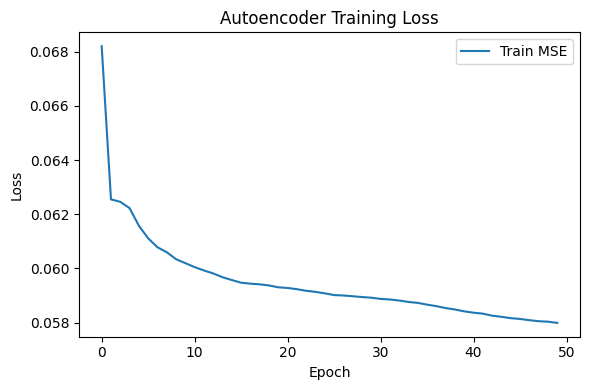

In [90]:
# Cell 4: Training loop

num_epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch in train_loader:
        # batch: (B, 2, 300)
        batch = batch.to(device)
        
        optimizer.zero_grad()
        recon, z = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train MSE: {epoch_loss:.6f}")

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [91]:
# Cell 5: Anomaly scoring function

def compute_anomaly_scores(model, windows_tensor, batch_size=256):
    """
    windows_tensor: (N, 2, 300) tensor of windows.
    Returns: anomaly_scores: (N,) tensor of reconstruction MSE per window.
    """
    model.eval()
    scores = []
    
    with torch.no_grad():
        for i in range(0, windows_tensor.size(0), batch_size):
            batch = windows_tensor[i:i+batch_size].to(device)
            recon, _ = model(batch)
            
            # Per-window MSE over channels and time
            mse_per_window = ((recon - batch) ** 2).mean(dim=(1, 2))
            scores.append(mse_per_window.cpu())
    
    scores = torch.cat(scores, dim=0)
    return scores

# Example usage on some test tensor: (N_test, 2, 300)
test_windows = torch.randn(500, 2, 300)  # replace with real data
anomaly_scores = compute_anomaly_scores(model, test_windows)
anomaly_scores[:10]

tensor([0.9912, 1.0140, 0.9715, 1.0342, 0.9873, 0.9087, 0.9013, 0.9138, 0.9457,
        0.9374])

Signal score: 0.398595
Signal score percentile vs background: 100.00%


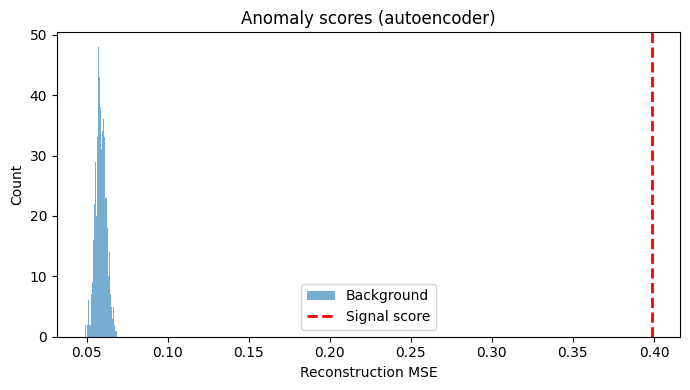

In [92]:
# Evaluate: 100 background windows + 1 injected signal window

windows_tensor = torch.stack([torch.tensor(eval_h), torch.tensor(eval_l)], dim=1)  # (N, 2, 300)

scores = compute_anomaly_scores(model, windows_tensor).cpu().numpy()
sig_score = float(scores[labels == 1][0])
bkg_scores = scores[labels == 0]
percentile = (bkg_scores < sig_score).mean()
print(f"Signal score: {sig_score:.6f}")
print(f"Signal score percentile vs background: {percentile * 100:.2f}%")

plt.figure(figsize=(7, 4))
plt.hist(bkg_scores, bins=30, alpha=0.6, label="Background")
plt.axvline(sig_score, color="red", linestyle="--", linewidth=2, label="Signal score")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Anomaly scores (autoencoder)")
plt.legend()
plt.tight_layout()
plt.show()


AUC: 1.0000


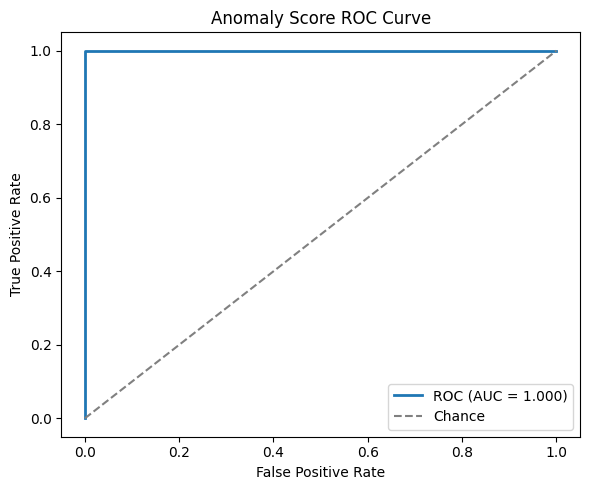

In [93]:
# Cell 6: AUC/ROC curve

fpr, tpr, _ = roc_curve(labels, scores)
auc_val = roc_auc_score(labels, scores)
print(f"AUC: {auc_val:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_val:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Anomaly Score ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

## Weakly Supervised Algorithm (Individual Backgrounds)

## Weakly Supervised Algorithm (Global Backgrounds)

In [198]:
# Compute mean/std from TRAINING BACKGROUND ONLY (important for avoiding leakage)
mean_h = train_h.mean()
std_h  = train_h.std() + 1e-8

mean_l = train_l.mean()
std_l  = train_l.std() + 1e-8

def standardize(h, l):
    h_n = (h - mean_h) / std_h
    l_n = (l - mean_l) / std_l
    return h_n.astype(np.float32), l_n.astype(np.float32)

train_hn, train_ln = standardize(train_h, train_l)
eval_hn,  eval_ln  = standardize(eval_h, eval_l)


In [199]:
class LIGOWindowDataset(Dataset):
    def __init__(self, hanford_windows, livingston_windows):
        assert hanford_windows.shape == livingston_windows.shape
        assert hanford_windows.shape[1] == 300

        self.h = torch.as_tensor(hanford_windows, dtype=torch.float32)
        self.l = torch.as_tensor(livingston_windows, dtype=torch.float32)

    def __len__(self):
        return self.h.shape[0]

    def __getitem__(self, idx):
        # (2, 300): channel 0 = H, channel 1 = L
        return torch.stack([self.h[idx], self.l[idx]], dim=0)

train_dataset = LIGOWindowDataset(train_hn, train_ln)
train_loader  = DataLoader(train_dataset, batch_size=256, shuffle=True)


In [200]:
class ConvAutoencoder1D(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),  # (N,16,150)
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),  # (N,32,75)
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),  # (N,64,38)
        )
        self.flatten_dim = 64 * 38
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, latent_dim),
        )
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.flatten_dim),
            nn.ReLU(inplace=True),
        )
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=0),
            nn.ReLU(inplace=True),  # (N,32,75)
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(inplace=True),  # (N,16,150)
            nn.ConvTranspose1d(16, 2, kernel_size=7, stride=2, padding=3, output_padding=1),
            # (N,2,300)
        )

    def forward(self, x):
        h = self.encoder_cnn(x)
        h = h.view(h.size(0), -1)
        z = self.encoder_fc(h)
        h2 = self.decoder_fc(z)
        h2 = h2.view(h2.size(0), 64, 38)
        xhat = self.decoder_cnn(h2)
        return xhat


Epoch 1/500 | Gen MSE: 1.000230
Epoch 2/500 | Gen MSE: 0.999564
Epoch 3/500 | Gen MSE: 0.991003
Epoch 4/500 | Gen MSE: 0.977044
Epoch 5/500 | Gen MSE: 0.968498
Epoch 6/500 | Gen MSE: 0.963135
Epoch 7/500 | Gen MSE: 0.959878
Epoch 8/500 | Gen MSE: 0.956926
Epoch 9/500 | Gen MSE: 0.954762
Epoch 10/500 | Gen MSE: 0.952500
Epoch 11/500 | Gen MSE: 0.951239
Epoch 12/500 | Gen MSE: 0.950087
Epoch 13/500 | Gen MSE: 0.949806
Epoch 14/500 | Gen MSE: 0.948912
Epoch 15/500 | Gen MSE: 0.947265
Epoch 16/500 | Gen MSE: 0.945373
Epoch 17/500 | Gen MSE: 0.942348
Epoch 18/500 | Gen MSE: 0.938878
Epoch 19/500 | Gen MSE: 0.936720
Epoch 20/500 | Gen MSE: 0.934506
Epoch 21/500 | Gen MSE: 0.932571
Epoch 22/500 | Gen MSE: 0.931592
Epoch 23/500 | Gen MSE: 0.930659
Epoch 24/500 | Gen MSE: 0.929693
Epoch 25/500 | Gen MSE: 0.928836
Epoch 26/500 | Gen MSE: 0.928351
Epoch 27/500 | Gen MSE: 0.928104
Epoch 28/500 | Gen MSE: 0.927305
Epoch 29/500 | Gen MSE: 0.926425
Epoch 30/500 | Gen MSE: 0.926227
Epoch 31/500 | Gen 

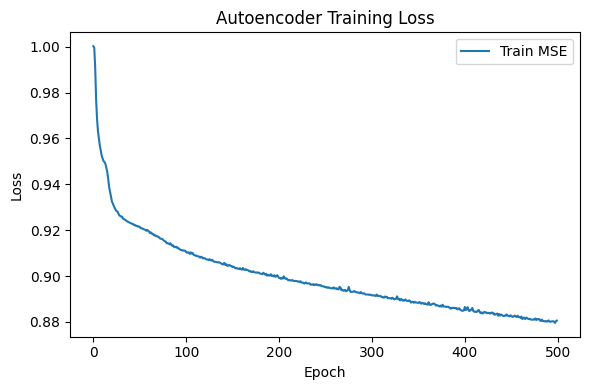

In [201]:
def train_generator(model, loader, epochs=50, lr=1e-3):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []

    for ep in range(epochs):
        total = 0.0
        count = 0
        for batch in loader:
            batch = batch.to(device)
            opt.zero_grad()
            recon = model(batch)
            loss = loss_fn(recon, batch)
            loss.backward()
            opt.step()

            total += loss.item() * batch.size(0)
            count += batch.size(0)
        train_losses.append(total / count)
        
        print(f"Epoch {ep+1}/{epochs} | Gen MSE: {total/count:.6f}")

    return model, train_losses

gen = ConvAutoencoder1D(latent_dim=32)
gen, train_losses = train_generator(gen, train_loader, epochs=500, lr=1e-3)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.tight_layout()
plt.show()



In [202]:
def generate_background_estimates(model, dataset, batch_size=256):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    X_hat_list = []

    with torch.no_grad():
        for xb in loader:
            xb = xb.to(device)              # (B,2,300)
            xhat = model(xb).cpu()          # (B,2,300)
            X_hat_list.append(xhat)

    return torch.cat(X_hat_list, dim=0)     # (N,2,300)

# Real training windows tensor (for classifier training)
X_real_train = torch.stack([torch.as_tensor(train_hn), torch.as_tensor(train_ln)], dim=1)  # (N,2,300)
X_hat_train  = generate_background_estimates(gen, train_dataset)                           # (N,2,300)

X_real_train.shape, X_hat_train.shape


(torch.Size([10000, 2, 300]), torch.Size([10000, 2, 300]))

In [203]:
class CNNClassifierWithTime(nn.Module):
    def __init__(self, use_time=False):
        super().__init__()
        self.use_time = use_time

        self.feature_net = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),  # (N,64,1)
        )

        in_dim = 64 + (1 if use_time else 0)
        self.head = nn.Linear(in_dim, 1)

    def forward(self, x, t=None):
        h = self.feature_net(x).squeeze(-1)  # (N,64)
        if self.use_time:
            if t is None:
                raise ValueError("use_time=True but no time provided")
            t = t.view(-1, 1)                # (N,1)
            h = torch.cat([h, t], dim=1)
        return self.head(h).squeeze(-1)      # (N,)


In [204]:
class RealVsEstimatedDatasetWithTime(Dataset):
    def __init__(self, X_real, X_est, time_idx):
        assert X_real.shape == X_est.shape
        N = X_real.size(0)

        self.X = torch.cat([X_real, X_est], dim=0)  # (2N,2,300)
        self.y = torch.cat([torch.ones(N), torch.zeros(N)], dim=0)

        # normalize time to [0,1]
        t = torch.as_tensor(time_idx, dtype=torch.float32)
        t = (t - t.min()) / (t.max() - t.min() + 1e-8)
        self.t = torch.cat([t, t], dim=0)          # (2N,)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.t[idx]

# Build time indices for training windows (0..N-1)
train_time_idx = np.arange(X_real_train.size(0), dtype=np.float32)

use_time = True  # set False if you want waveform-only classifier
clf_dataset = RealVsEstimatedDatasetWithTime(X_real_train, X_hat_train, train_time_idx)
clf_loader  = DataLoader(clf_dataset, batch_size=256, shuffle=True)


Epoch 1/10 | BCE: 0.281174
Epoch 2/10 | BCE: 0.001192
Epoch 3/10 | BCE: 0.000380
Epoch 4/10 | BCE: 0.000196
Epoch 5/10 | BCE: 0.000119
Epoch 6/10 | BCE: 0.000079
Epoch 7/10 | BCE: 0.000056
Epoch 8/10 | BCE: 0.000042
Epoch 9/10 | BCE: 0.000033
Epoch 10/10 | BCE: 0.000026


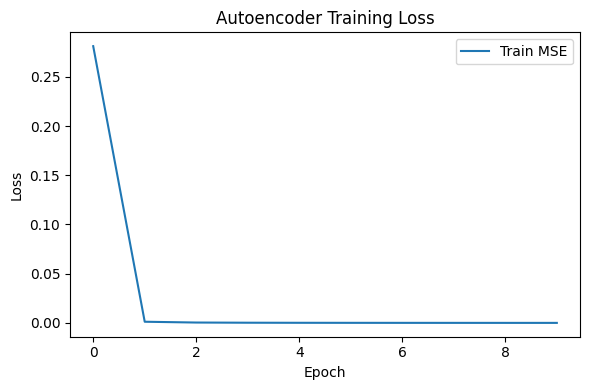

In [205]:
def train_classifier(model, loader, epochs=10, lr=1e-3):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    train_classifier_losses = []

    for ep in range(epochs):
        total = 0.0
        count = 0

        for xb, yb, tb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            tb = tb.to(device)

            opt.zero_grad()
            logits = model(xb, tb if model.use_time else None)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            total += loss.item() * xb.size(0)
            count += xb.size(0)
        train_classifier_losses.append(total / count)

        print(f"Epoch {ep+1}/{epochs} | BCE: {total/count:.6f}")

    return model, train_classifier_losses

clf = CNNClassifierWithTime(use_time=use_time)
clf, train_classifier_losses = train_classifier(clf, clf_loader, epochs=10, lr=1e-3)

plt.figure(figsize=(6,4))
plt.plot(train_classifier_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [206]:
def anomaly_scores(model, h_windows, l_windows, batch_size=512):
    X = torch.stack([torch.as_tensor(h_windows), torch.as_tensor(l_windows)], dim=1)  # (N,2,300)
    model.eval()
    scores = []

    # If using time, make a normalized 0..1 index for the eval set
    if model.use_time:
        t = torch.arange(X.size(0), dtype=torch.float32)
        t = (t - t.min()) / (t.max() - t.min() + 1e-8)

    with torch.no_grad():
        for i in range(0, X.size(0), batch_size):
            xb = X[i:i+batch_size].to(device)
            if model.use_time:
                tb = t[i:i+batch_size].to(device)
                logits = model(xb, tb)
            else:
                logits = model(xb, None)
            scores.append(torch.sigmoid(logits).cpu())

    return torch.cat(scores, dim=0)  # (N,)

scores_eval = anomaly_scores(clf, eval_hn, eval_ln)
scores_eval[:10], scores_eval.argmax().item(), (len(scores_eval) - 1)


(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]),
 123,
 500)

/var/folders/4h/btz0vs815bgflhf3shpm_mwr0000gn/T/ipykernel_71790/1994125385.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sig_score = float(scores_np[labels == 1])


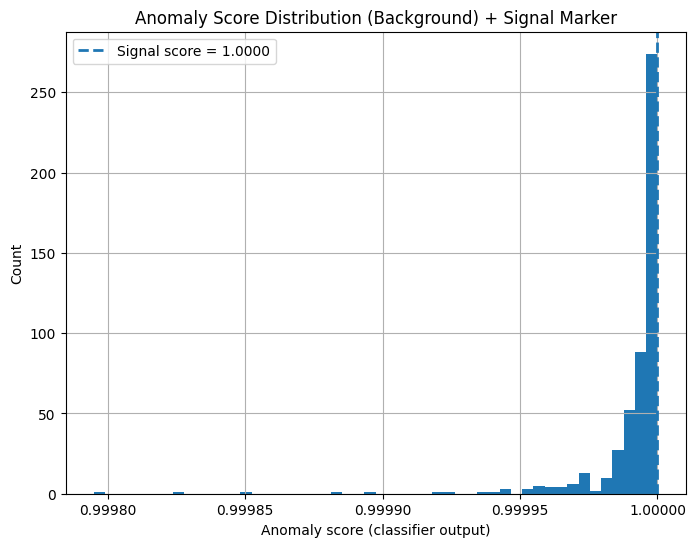

Signal score is at the 99.40th percentile of the background scores.


In [207]:
scores_np = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

bg_scores = scores_np[labels == 0]
sig_score = float(scores_np[labels == 1])

plt.figure(figsize=(8,6))
plt.hist(bg_scores, bins=50)
plt.axvline(sig_score, linestyle="--", linewidth=2, label=f"Signal score = {sig_score:.4f}")
plt.xlabel("Anomaly score (classifier output)")
plt.ylabel("Count")
plt.title("Anomaly Score Distribution (Background) + Signal Marker")
plt.legend()
plt.grid(True)
plt.show()

# Optional quick diagnostic: where signal sits in bg distribution
percentile = 100.0 * (bg_scores < sig_score).mean()
print(f"Signal score is at the {percentile:.2f}th percentile of the background scores.")


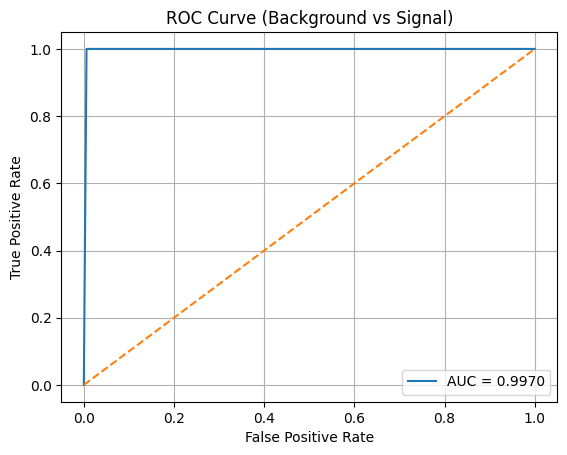

In [208]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

# Convert scores to a NumPy array
scores = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

# ROC points + AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc = roc_auc_score(labels, scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Background vs Signal)")
plt.legend()
plt.grid(True)
plt.show()


In [209]:
# # --- split background into signal/control regions and fit preprocessing ---
# SR_bkg_raw, CR_bkg_raw = gw_background_split(raw_bkg, resample_seed=42)
# # I am instead basing the preprocessing params on the signal region. IMPORTANT NOTE for KRISH
# # pre_params = preprocess_params_fit(CR_bkg_raw)
# SR_sig_raw, CR_sig_raw = gw_background_split(combined_signal_raw, resample_seed=42)
# pre_params = preprocess_params_fit(SR_sig_raw)
# feature_min = pre_params["min"]
# feature_max = pre_params["max"]
# feature_range = feature_max - feature_min
# buffer = np.maximum(feature_range * 0.1, 1e-3)
# pre_params["min"] = feature_min - buffer
# pre_params["max"] = feature_max + buffer
# print("Pre_params:", pre_params)

# def transform_with_params(data, params, clip_eps=1e-6):
#     feature_min = params["min"]
#     feature_max = params["max"]
#     feature_mean = params["mean"]
#     feature_std = params["std"]

#     denom = feature_max - feature_min
#     denom = np.where(denom == 0, 1e-6, denom)
#     x = data[:, 1:-1]
#     x_norm = (x - feature_min) / denom
#     x_norm = np.clip(x_norm, clip_eps, 1 - clip_eps)
#     logit = np.log(x_norm / (1 - x_norm))
#     mask = np.isfinite(logit).all(axis=1)

#     transformed = np.hstack([data[:, 0:1], logit, data[:, -1:]])[mask]
#     transformed[:, 1:-1] = standardize(transformed[:, 1:-1], feature_mean, feature_std)
#     return transformed, data[mask]

# CR_processed, CR_aligned_raw = transform_with_params(CR_bkg_raw, pre_params)
# SR_bkg_processed, SR_bkg_aligned_raw = transform_with_params(SR_bkg_raw, pre_params)
# SR_sig_processed, SR_sig_aligned_raw = transform_with_params(SR_sig_raw, pre_params)

# print(f"Control-region processed shape: {CR_processed.shape}")
# print(f"Signal-region background shape: {SR_bkg_processed.shape}")
# print(f"Signal-region injected signal shape: {SR_sig_processed.shape}")

# # Build background mass/time PDF for later mixing
# hist_counts, hist_bins = np.histogram(SR_bkg_aligned_raw[:, 0], bins=40, density=True)
# mass_density = rv_histogram((hist_counts, hist_bins))

# plt.clf()
# # plt.scatter(SR_bkg_raw[:, 0], SR_bkg_raw[:, 1], label='Signal Region Background Time Distribution')
# # plt.scatter(CR_bkg_raw[:, 0], CR_bkg_raw[:, 1], label='Control Region Background Time Distribution')
# plt.scatter(SR_bkg_processed[:, 0], SR_bkg_processed[:, 1], label='Processed Signal Region Background Time Distribution')
# plt.scatter(SR_sig_processed[:, 0], SR_sig_processed[:, 1], label='Processed Signal+Background Time Distribution')
# # plt.scatter(CR_sig_raw[:, 0], CR_sig_raw[:, 1], label='Signal Region Raw Signal+Background Time Distribution')
# plt.scatter(CR_processed[:, 0], CR_processed[:, 1], label='Processed Control Region Background Time Distribution')
# plt.xlabel('Time (s)')
# plt.ylabel('Strain')
# plt.legend()
# plt.title('Gravitational Wave Data Processing')
# plt.show()